In [18]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, PReLU, Input, Reshape, Layer, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import numpy as np
from astropy.io import fits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
from scipy.ndimage import gaussian_filter1d
import tensorflow_probability as tfp 


r'''

for cpu to test with tensorflow_probability

'''

def build_encoder(input_shape, latent_dim):
    input_layer = Input(shape=input_shape)

    # Convolutional Layers
    x = Conv1D(filters=128, kernel_size=5, padding='valid', name='conv1')(input_layer)
    x = PReLU(name='prelu1')(x)
    x = MaxPooling1D(pool_size=2, name='maxpool1')(x)

    x = Conv1D(filters=256, kernel_size=11, padding='valid', name='conv2')(x)
    x = PReLU(name='prelu2')(x)
    x = MaxPooling1D(pool_size=2, name='maxpool2')(x)

    x = Conv1D(filters=512, kernel_size=21, padding='valid', name='conv3')(x)
    x = PReLU(name='prelu3')(x)
    x = MaxPooling1D(pool_size=2, name='maxpool3')(x)

    # Flatten the output from Conv layers
    x = Flatten(name='flatten')(x)

    # Fully Connected Layers
    x = Dense(256, name='dense1')(x)
    x = PReLU(name='prelu4')(x)
    x = Dense(128, name='dense2')(x)
    x = PReLU(name='prelu5')(x)
    x = Dense(64, name='dense3')(x)
    x = PReLU(name='prelu6')(x)

    # Latent Space
    latent_space = Dense(latent_dim, name='latent_space')(x)

    return Model(input_layer, latent_space, name='encoder')

class InterpolationLayer(Layer):
    def __init__(self, observed_range, output_dim, **kwargs):
        super(InterpolationLayer, self).__init__(**kwargs)
        self.observed_range = observed_range
        self.output_dim = output_dim

    def call(self, inputs):
        x, y_ref = inputs
        obs_x = tf.linspace(
            tf.cast(self.observed_range[0], tf.float32), 
            tf.cast(self.observed_range[1], tf.float32), 
            self.output_dim
        )

        # Interpolate at the points defined by obs_x
        interpolated_output = tfp.math.interp_regular_1d_grid(
            obs_x,
            x_ref_min=tf.cast(self.observed_range[0], tf.float32), 
            x_ref_max=tf.cast(self.observed_range[1], tf.float32),
            y_ref=y_ref,  # the values from the upsampled layer
            axis=-1
        )
        return interpolated_output

# In your build_decoder function:
def build_decoder(latent_dim, output_dim, rest_range, observed_range, observed_resolution, upsample_factor):
    # Inputs: latent vector and scalar z
    latent_input = Input(shape=(latent_dim,), name='latent_input')
    z_input = Input(shape=(1,), name='z')  # Scalar input for z
    
    x = Dense(64)(latent_input) 
    x = PReLU()(x)     
    x = Dense(256)(x) 
    x = PReLU()(x) 
    x = Dense(1024)(x) 
    x = PReLU()(x) 

    # Generate rest frame grid 
    min_rest_x, max_rest_x = rest_range 
    rest_length = int((max_rest_x - min_rest_x) / observed_resolution * upsample_factor) 
    rest_x = tf.linspace(min_rest_x, max_rest_x, rest_length) 
    #print(f'Rest Length: {rest_length}; Min X: {min_rest_x}; Max X: {max_rest_x}; Resolution: {(max_rest_x-min_rest_x)/rest_length}')
    
    # Upsample Layer 
    x = Dense(rest_length)(x) 
    x = PReLU()(x) 

    print(observed_range[0])
    print('$$$$')

    observed_range_rest = np.array([observed_range[0], observed_range[1]])/(1+z_input)

    # Use the custom InterpolationLayer --> with redshifted version of rest wavelength --> calculate in rest frame???
    #rest_x_redshifted = rest_x * (1 + z_input)
    #interpolated_output = InterpolationLayer(observed_range, output_dim)([rest_x_redshifted, x])

    # use the custom InterpolationLayer --> in rest frame? if this works, it's departure from Spender. 
    interpolated_output = InterpolationLayer(np.array(observed_range)/(1+z_input.astype(), output_dim)([rest_x, x]))

    # Return interpolated output
    return Model([latent_input, z_input], interpolated_output, name='decoder')

def build_autoencoder(input_shape, latent_dim, z_range, observed_range, observed_resolution, upsample_factor):
    spectra_input = Input(shape=input_shape, name='spectra_input')
    
    # Building the encoder 
    encoder = build_encoder(input_shape, latent_dim)
    latent_space = encoder(spectra_input)
    
    # Scalar z input 
    z_input = Input(shape=(1,), name='z_input')
    
    # Building the decoder input  latent vector and scalar z

    z_range = np.array(z_range).astype(np.float32)

    rest_range = [observed_range[0]/(1+z_range[1]), observed_range[1]/(1+z_range[0])] # issue is z_range not observed_range. 

    decoder = build_decoder(latent_dim, input_shape[0], rest_range, observed_range, observed_resolution, upsample_factor)
    reconstructed_output = decoder([latent_space, z_input])

    return Model(inputs=[spectra_input, z_input], outputs=reconstructed_output, name='autoencoder')

In [19]:
observed_range = [3550, 10400]
observed_length = 1500
observed_resolution = (observed_range[1]-observed_range[0])/observed_length
z_range = [1.5, 2.2]

autoencoder = build_autoencoder(input_shape=(1500, 1), latent_dim=10, z_range=z_range, observed_range=observed_range, observed_resolution=observed_resolution, upsample_factor=2)

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

3550
$$$$


ValueError: A KerasTensor is symbolic: it's a placeholder for a shape an a dtype. It doesn't have any actual numerical value. You cannot convert it to a NumPy array.

In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.ndimage import gaussian_filter1d
from astropy.io import fits

data_dir = '/Users/tkiker/Documents/GitHub/AGN-UMAP/data/sdss_spectra'

file_names = []
spectra = []
zs = []

x = np.linspace(observed_range[0], observed_range[1], observed_length)

for file_name in os.listdir(data_dir)[0:500]:
    hdul = fits.open(os.path.join(data_dir, file_name))
    
    z = hdul[2].data['z'][0]

    if z_range[0] <= z <= z_range[1]:

        data = hdul[1].data

        wavelength = 10**data["loglam"]
        flux = data["flux"]

        # Apply a Gaussian filter to smooth the flux
        flux = gaussian_filter1d(flux, sigma=3)
        
        # Interpolate the flux to match the x array
        flux = np.interp(x, wavelength, flux)

        # Convert to rest-frame wavelength
        rest_wavelength = x / (1 + z)

        # Normalize the flux using a range of rest wavelengths
        norm_mask = np.logical_and(rest_wavelength >= 2000, rest_wavelength <= 2500)
        flux /= np.median(flux[norm_mask])

        spectra.append(flux)
        file_names.append(file_name)
        zs.append(z)

# Convert to numpy arrays
spectra = np.array(spectra)
zs = np.array(zs)
file_names = np.array(file_names)

# Split the data into training and test sets (you can adjust test_size and random_state)
spectra_train, spectra_test, zs_train, zs_test, file_names_train, file_names_test = train_test_split(
    spectra, zs, file_names, test_size=0.2, random_state=42
)

print("Training set size:", len(spectra_train))
print("Test set size:", len(spectra_test))

In [ ]:
# Train the model using the `fit` method
history = autoencoder.fit(
    [spectra_train, zs_train],  # Training data for both inputs
    spectra_train,              # The target output is the same as the input in autoencoders
    epochs=5,                  # Number of epochs to train
    batch_size=32,              # Size of each batch
    validation_data=([spectra_test, zs_test], spectra_test),  # Validation data
    verbose=1                   # Show training progress
)

# After training, you can evaluate the model on the test set or save the model
autoencoder.save('autoencoder_model.h5')

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step


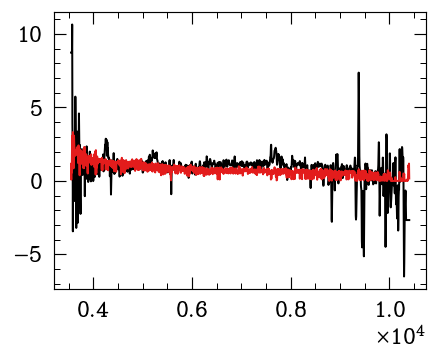

<Figure size 720x720 with 0 Axes>

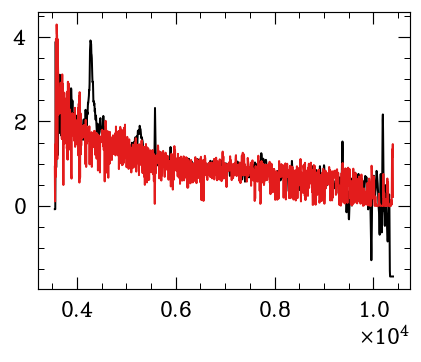

<Figure size 720x720 with 0 Axes>

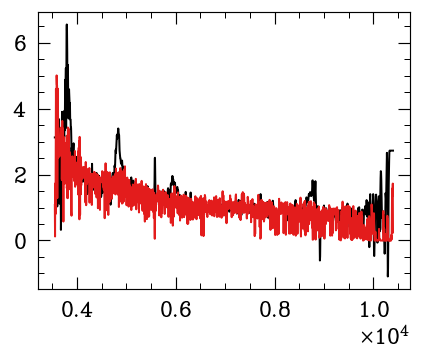

<Figure size 720x720 with 0 Axes>

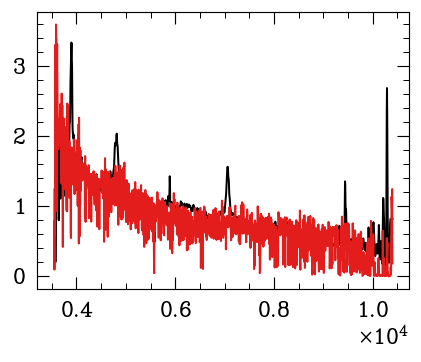

<Figure size 720x720 with 0 Axes>

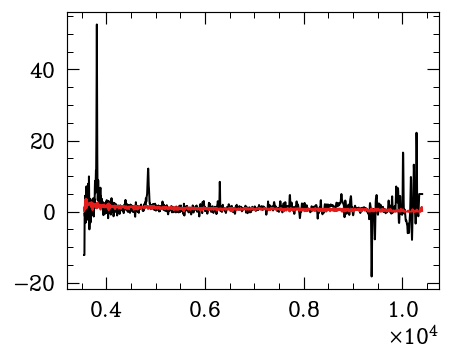

<Figure size 720x720 with 0 Axes>

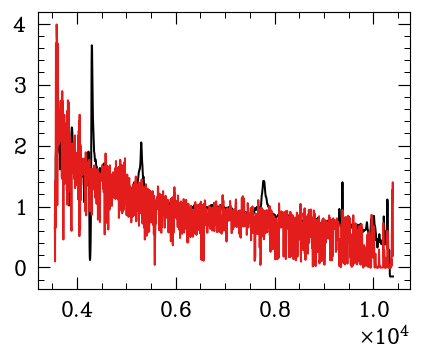

<Figure size 720x720 with 0 Axes>

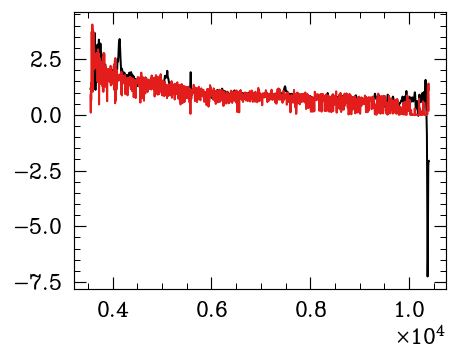

<Figure size 720x720 with 0 Axes>

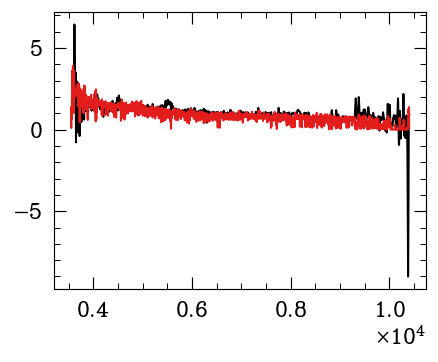

<Figure size 720x720 with 0 Axes>

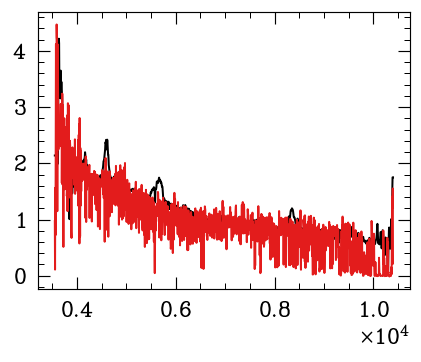

<Figure size 720x720 with 0 Axes>

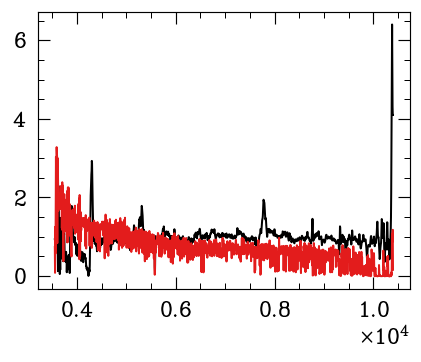

<Figure size 720x720 with 0 Axes>

In [8]:
import matplotlib.pyplot as plt 
import smplotlib 

hist = history.history

predictions = autoencoder.predict([spectra_test, zs_test])

for i in range(10):
    fig, ax = plt.subplots(figsize=(4, 3))
    x = np.linspace(observed_range[0], observed_range[1], observed_length)
    ax.plot(x, spectra_test[i])
    ax.plot(x, predictions[i])

    plt.show()
    plt.clf()